In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Linear Regression Consulting Project

You've been contracted by Hyundai Heavy Industries to help them build a predictive model for some ships. [Hyundai Heavy Industries](http://www.hyundai.eu/en) is one of the world's largest ship manufacturing companies and builds cruise liners.

You've been flown to their headquarters in Ulsan, South Korea to help them give accurate estimates of how many crew members a ship will require.

They are currently building new ships for some customers and want you to create a model and use it to predict how many crew members the ships will need.

Here is what the data looks like so far:

    Description: Measurements of ship size, capacity, crew, and age for 158 cruise
    ships.


    Variables/Columns
    Ship Name     1-20
    Cruise Line   21-40
    Age (as of 2013)   46-48
    Tonnage (1000s of tons)   50-56
    passengers (100s)   58-64
    Length (100s of feet)  66-72
    Cabins  (100s)   74-80
    Passenger Density   82-88
    Crew  (100s)   90-96
    
It is saved in a csv file for you called "cruise_ship_info.csv". Your job is to create a regression model that will help predict how many crew members will be needed for future ships. The client also mentioned that they have found that particular cruise lines will differ in acceptable crew counts, so it is most likely an important feature to include in your analysis!

Once you've created the model and tested it for a quick check on how well you can expect it to perform, make sure you take a look at why it performs so well!

In [16]:
import pyspark
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName('cruise').getOrCreate()

In [35]:
cruise_ship = spark.read.csv('/content/drive/My Drive/cruise_ship_info.csv', inferSchema=True, header=True)

In [18]:
cruise_ship.printSchema()

root
 |-- Ship_name: string (nullable = true)
 |-- Cruise_line: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Tonnage: double (nullable = true)
 |-- passengers: double (nullable = true)
 |-- length: double (nullable = true)
 |-- cabins: double (nullable = true)
 |-- passenger_density: double (nullable = true)
 |-- crew: double (nullable = true)



In [19]:
cruise_ship.show()

+-----------+-----------+---+------------------+----------+------+------+-----------------+----+
|  Ship_name|Cruise_line|Age|           Tonnage|passengers|length|cabins|passenger_density|crew|
+-----------+-----------+---+------------------+----------+------+------+-----------------+----+
|    Journey|    Azamara|  6|30.276999999999997|      6.94|  5.94|  3.55|            42.64|3.55|
|      Quest|    Azamara|  6|30.276999999999997|      6.94|  5.94|  3.55|            42.64|3.55|
|Celebration|   Carnival| 26|            47.262|     14.86|  7.22|  7.43|             31.8| 6.7|
|   Conquest|   Carnival| 11|             110.0|     29.74|  9.53| 14.88|            36.99|19.1|
|    Destiny|   Carnival| 17|           101.353|     26.42|  8.92| 13.21|            38.36|10.0|
|    Ecstasy|   Carnival| 22|            70.367|     20.52|  8.55|  10.2|            34.29| 9.2|
|    Elation|   Carnival| 15|            70.367|     20.52|  8.55|  10.2|            34.29| 9.2|
|    Fantasy|   Carnival| 23| 

In [20]:
cruise_ship.describe().show()

+-------+---------+-----------+------------------+------------------+-----------------+-----------------+------------------+-----------------+-----------------+
|summary|Ship_name|Cruise_line|               Age|           Tonnage|       passengers|           length|            cabins|passenger_density|             crew|
+-------+---------+-----------+------------------+------------------+-----------------+-----------------+------------------+-----------------+-----------------+
|  count|      158|        158|               158|               158|              158|              158|               158|              158|              158|
|   mean| Infinity|       NULL|15.689873417721518| 71.28467088607599|18.45740506329114|8.130632911392404| 8.830000000000005|39.90094936708861|7.794177215189873|
| stddev|     NULL|       NULL| 7.615691058751413|37.229540025907866|9.677094775143416|1.793473548054825|4.4714172221480615| 8.63921711391542|3.503486564627034|
|    min|Adventure|    Azamara|   

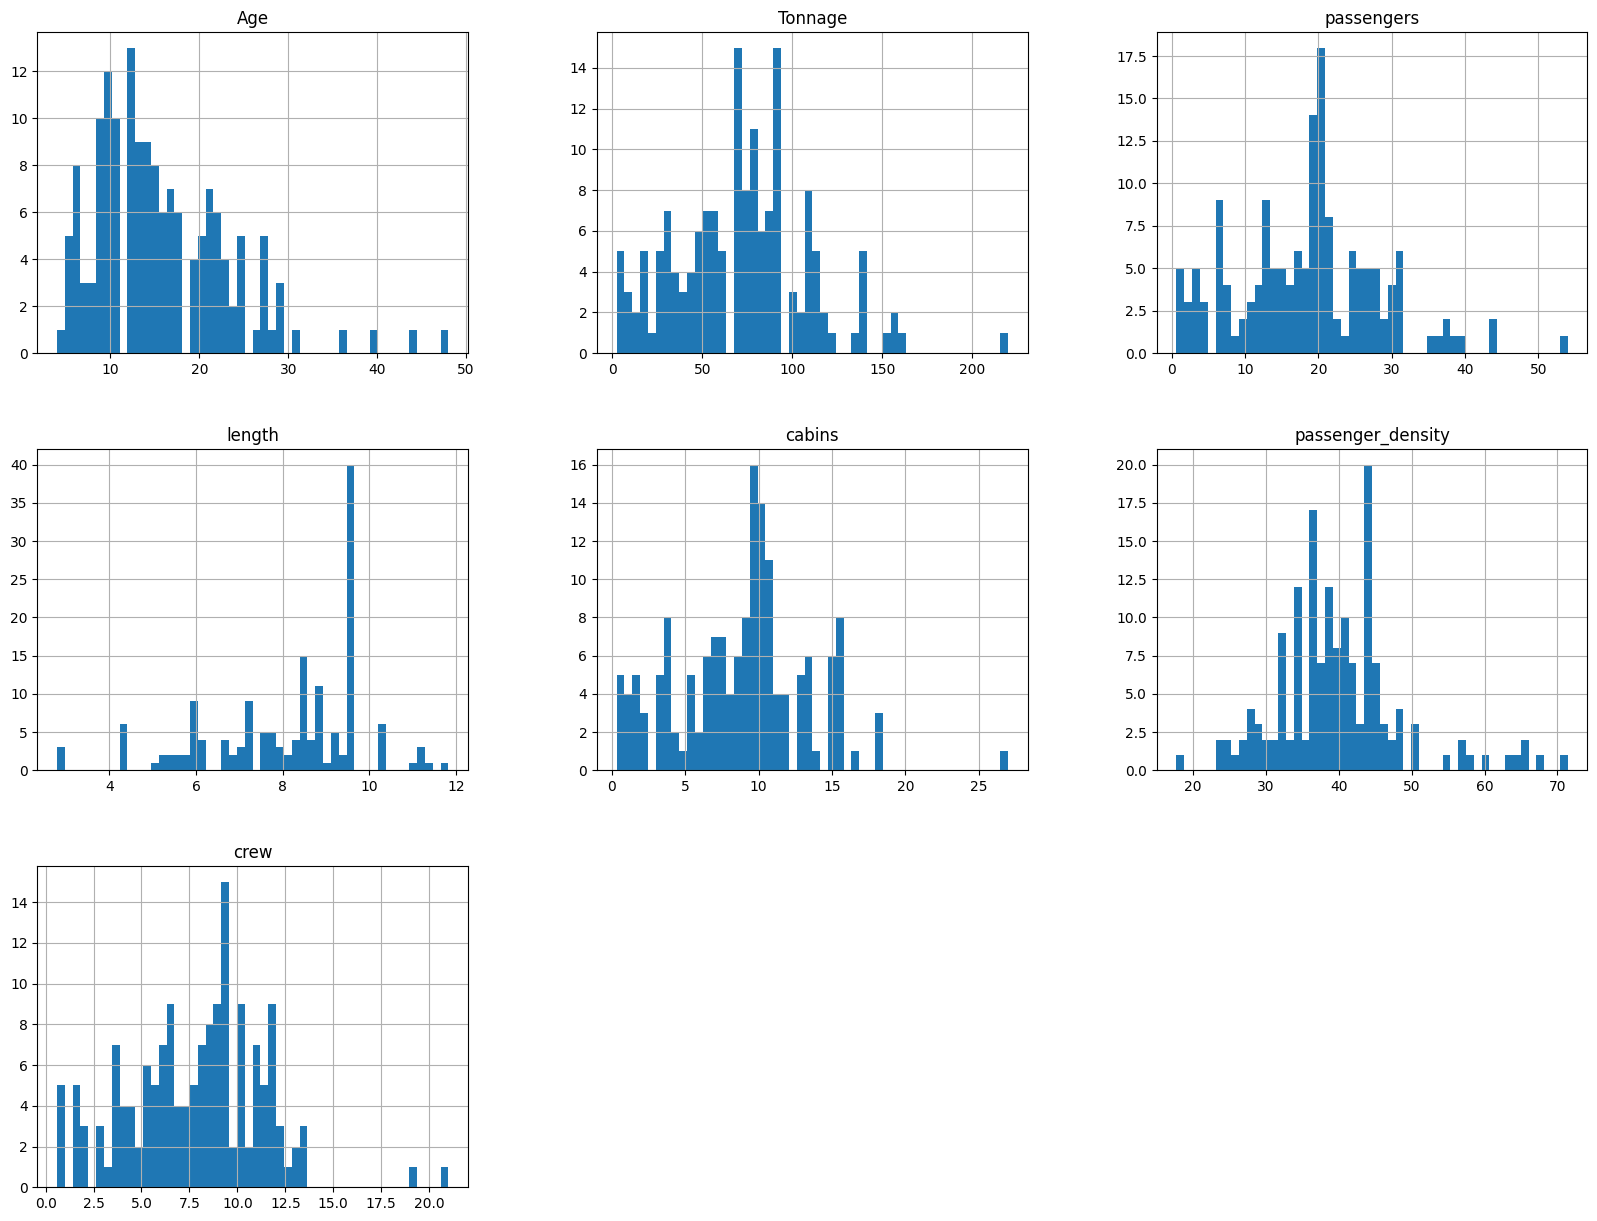

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

cruise_ship.toPandas().hist(bins=50, figsize=(20,15))
plt.show()

### Handing Missing Values

In [22]:
# Tính tổng số giá trị null trong mỗi cột
from pyspark.sql.functions import col, sum

null_counts = cruise_ship.select([sum(col(c).isNull().cast("int")).alias(c) for c in cruise_ship.columns])
null_counts.show()

+---------+-----------+---+-------+----------+------+------+-----------------+----+
|Ship_name|Cruise_line|Age|Tonnage|passengers|length|cabins|passenger_density|crew|
+---------+-----------+---+-------+----------+------+------+-----------------+----+
|        0|          0|  0|      0|         0|     0|     0|                0|   0|
+---------+-----------+---+-------+----------+------+------+-----------------+----+



### Duplicate Data

In [25]:
# Đếm tổng số dòng trùng lặp
duplicate_count = cruise_ship.groupBy(cruise_ship.columns).count().filter(col("count") > 1).agg(sum(col("count") - 1)).collect()[0][0]

print(f"Total of duplicate row: {duplicate_count}")

Total of duplicate row: None


### Analysis

In [26]:
from pyspark.ml.feature import StringIndexer

# Mã hóa biến Cruise_line
indexer = StringIndexer(inputCol="Cruise_line", outputCol="Cruise_line_index")
df = indexer.fit(cruise_ship).transform(cruise_ship)


In [27]:
df.show()

+-----------+-----------+---+------------------+----------+------+------+-----------------+----+-----------------+
|  Ship_name|Cruise_line|Age|           Tonnage|passengers|length|cabins|passenger_density|crew|Cruise_line_index|
+-----------+-----------+---+------------------+----------+------+------+-----------------+----+-----------------+
|    Journey|    Azamara|  6|30.276999999999997|      6.94|  5.94|  3.55|            42.64|3.55|             16.0|
|      Quest|    Azamara|  6|30.276999999999997|      6.94|  5.94|  3.55|            42.64|3.55|             16.0|
|Celebration|   Carnival| 26|            47.262|     14.86|  7.22|  7.43|             31.8| 6.7|              1.0|
|   Conquest|   Carnival| 11|             110.0|     29.74|  9.53| 14.88|            36.99|19.1|              1.0|
|    Destiny|   Carnival| 17|           101.353|     26.42|  8.92| 13.21|            38.36|10.0|              1.0|
|    Ecstasy|   Carnival| 22|            70.367|     20.52|  8.55|  10.2|       

In [28]:
from pyspark.ml.feature import VectorAssembler

# Xác định các cột đặc trưng
feature_cols = ["Cruise_line_index", "Age", "Tonnage", "passengers", "length", "cabins", "passenger_density"]

# Gộp các cột thành một vector
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
df = assembler.transform(df)

# Chọn các cột cần thiết cho mô hình
df = df.select("features", "crew")
df.show()

+--------------------+----+
|            features|crew|
+--------------------+----+
|[16.0,6.0,30.2769...|3.55|
|[16.0,6.0,30.2769...|3.55|
|[1.0,26.0,47.262,...| 6.7|
|[1.0,11.0,110.0,2...|19.1|
|[1.0,17.0,101.353...|10.0|
|[1.0,22.0,70.367,...| 9.2|
|[1.0,15.0,70.367,...| 9.2|
|[1.0,23.0,70.367,...| 9.2|
|[1.0,19.0,70.367,...| 9.2|
|[1.0,6.0,110.2389...|11.5|
|[1.0,10.0,110.0,2...|11.6|
|[1.0,28.0,46.052,...| 6.6|
|[1.0,18.0,70.367,...| 9.2|
|[1.0,17.0,70.367,...| 9.2|
|[1.0,11.0,86.0,21...| 9.3|
|[1.0,8.0,110.0,29...|11.6|
|[1.0,9.0,88.5,21....|10.3|
|[1.0,15.0,70.367,...| 9.2|
|[1.0,12.0,88.5,21...| 9.3|
|[1.0,20.0,70.367,...| 9.2|
+--------------------+----+
only showing top 20 rows



In [29]:
# Chia dữ liệu thành training (80%) và testing (20%)
train_data, test_data = df.randomSplit([0.8, 0.2], seed=42)


In [30]:
from pyspark.ml.regression import LinearRegression

# Tạo mô hình Linear Regression
lr = LinearRegression(featuresCol="features", labelCol="crew")

# Huấn luyện mô hình trên tập training
lr_model = lr.fit(train_data)


In [31]:
# Đánh giá mô hình trên tập test
test_results = lr_model.evaluate(test_data)

# In các chỉ số đánh giá
print("Root Mean Squared Error (RMSE):", test_results.rootMeanSquaredError)
print("R² Score:", test_results.r2)


Root Mean Squared Error (RMSE): 1.6380351802665358
R² Score: 0.8052483620036102


In [32]:
print("Coefficients:", lr_model.coefficients)
print("Intercept:", lr_model.intercept)


Coefficients: [0.04248355634736307,-0.01110383260752294,0.018931412460789294,-0.1369834494852146,0.4905411057451113,0.709319945364829,-0.010291408760212914]
Intercept: -0.9480566643801185


In [33]:
# Dự đoán số lượng crew
predictions = lr_model.transform(test_data)
predictions.select("features", "crew", "prediction").show()


+--------------------+-----+------------------+
|            features| crew|        prediction|
+--------------------+-----+------------------+
|[0.0,6.0,158.0,43...| 13.6|13.904515881705699|
|[0.0,10.0,138.0,3...|11.85|12.879290903841879|
|[0.0,11.0,138.0,3...|11.85|12.868187071234356|
|[0.0,15.0,78.491,...|  6.6|  8.28574281387627|
|[0.0,21.0,73.941,...| 8.22| 8.833662188256815|
|[1.0,6.0,110.2389...| 11.5| 10.95244867987839|
|[1.0,11.0,110.0,2...| 19.1|11.829710631020324|
|[1.0,15.0,70.367,...|  9.2| 8.525413210500414|
|[2.0,6.0,113.0,37...| 12.0| 11.43047317241908|
|[2.0,7.0,116.0,31...| 12.0| 12.33279348063108|
|[2.0,8.0,77.499,1...|  9.0| 8.549988805145825|
|[2.0,9.0,113.0,26...|12.38|11.227026774638627|
|[2.0,10.0,91.6270...|  9.0| 9.308524284430634|
|[2.0,14.0,30.2769...| 3.73|3.5096432898637557|
|[3.0,5.0,86.0,21....|  8.0| 9.289949251456212|
|[3.0,17.0,55.451,...| 5.88|5.8724062329838835|
|[4.0,8.0,91.0,22....| 11.0|10.056871659839832|
|[6.0,5.0,122.0,28...|  6.7| 7.241473166